In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image

In [2]:
tf.random.set_seed(123)
tf.random.set_seed(2)
np.random.seed(1)

print(os.listdir("."))

['.ipynb_checkpoints', 'assets', 'data', 'dcgan.gif', 'dcgan.ipynb', 'image_at_epoch_0001.png', 'image_at_epoch_0050.png', 'imports.py', 'keras_metadata.pb', 'last_model.pickle', 'last_model_2.h5', 'last_model_2_fixed.h5', 'model_fixel_1epoch.h5', 'model_fixel_1epoch_overnight.h5', 'my_model.h5', 'Novo Documento de Texto.txt', 'PFC_Colab.ipynb', 'saved_model.pb', 'training_checkpoints', 'variables', 'venv']


In [3]:
ImagePath="D://PFC_code/data/training"

In [5]:
WIDTH=224
HEIGHT=224

def ExtractInput():
    img_files = os.listdir(ImagePath)
    total_files = len(img_files)
    batch_len = 8
    start = 0
    while start<total_files-1:
        imgs_l = []
        imgs_ab = []
        for i in range(start, min(start + batch_len, total_files)):
            imageDir = img_files[i]
            img = cv2.imread(os.path.join(ImagePath, imageDir))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            img = img.astype(np.float32)
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_l = img_l - 50
            img_l = img_l/100
            img_ab = img_ab/110
            img_ab = img_ab - 1
            imgs_l.append(img_l.reshape((WIDTH, HEIGHT, 1)))
            imgs_ab.append(img_ab.reshape((WIDTH, HEIGHT, 2)))
        yield np.array(imgs_l), np.array(imgs_ab)
        start += batch_len


In [6]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [6]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)

Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [8]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [7]:
LEARNING_RATE = 0.01
Model_Colourization.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss='mean_squared_error')


In [8]:
Model_Colourization.fit(ExtractInput(), epochs=20)

Epoch 1/20
4500/4500 [==============================] - 1510s 334ms/step - loss: 0.6459
Epoch 2/20
4500/4500 [==============================] - 0s 5us/step - loss: 0.6459


In [10]:
Model_Colourization.save('model_fixel_1epoch_overnight.h5')

In [ ]:
Prediction = Model_Colourization.predict(img_l_reshaped)
Prediction = Prediction + 1
Prediction = Prediction*110
Prediction = Prediction.reshape((224,224,2))

In [ ]:
Model_Colourization.predict(img_l_reshaped)

In [80]:
Model_Colourization = tf.keras.models.load_model('model_fixel_1epoch.h5')

In [ ]:
def ExtractTestInput(path):
    print('Isfile', os.path.isfile(path))
    img = cv2.imread(path)
    # print(img)
    # plt.imshow(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(img)
    # plt.imshow(img)


    test = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)  
    # print(test[:,:,0])
    # print(test[:,:,1])
    # print(test[:,:,2])

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    #img_l -= 50
    # print(img)
    # plt.imshow(img)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_= img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_ab = img_lab_rs[:,:,1:] # pull out L channel
    # print(img_lab_rs[:,:,0])
    # print(img_lab_rs[:,:,1])
    # print(img_lab_rs[:,:,2])
    #img_l -= 50
    img_l_reshaped = img_l.reshape((224,224,1))
    img_ab_reshaped = img_ab.reshape(( 224,224,2))
    
    return img_l_reshaped, img_ab_reshaped

In [ ]:
os.listdir(ImagePath)[-10:]

['10004_9455.jpg',
 '10004_9516.jpg',
 '10004_9577.jpg',
 '10004_9638.jpg',
 '10004_9699.jpg',
 '10004_976.jpg',
 '10004_9760.jpg',
 '10004_9821.jpg',
 '10004_9882.jpg',
 '10004_9943.jpg']

In [ ]:
test_path = os.path.join(ImagePath, "10004_9943.jpg")
image_for_test, img_ab = ExtractTestInput(test_path)

Isfile True


In [ ]:
# Prediction = Model_Colourization.predict(image_for_test)

In [ ]:
image_for_test.shape

(224, 224, 1)

In [ ]:
img_ab.shape

(224, 224, 2)

In [1]:
score = Model_Colourization.evaluate(image_for_test, img_ab)
print('Test score:', score)
# print('Test accuracy:', acc)

NameError: name 'Model_Colourization' is not defined

In [ ]:
# test_path = os.path.join(ImagePath, "10004_9943.jpg")
# image_for_test, img_ab = ExtractTestInput(test_path)
# Prediction = Model_Colourization.predict(image_for_test)
# Prediction = Prediction*128
# Prediction = Prediction.reshape(224,224,2)

Isfile True


In [ ]:
# Prediction[Prediction<0] = 0

In [31]:
########################################
########################################
########################################

In [ ]:
img_files = os.listdir(ImagePath)
batch_img_files = img_files[:10000]

In [31]:
img_files = "D://PFC_code/data/training_2/MULTI_24Jul2015_ACOMP_TIFF.tif"
# batch_img_files = img_files[:10000]

In [88]:
import matplotlib.pyplot as plt

In [89]:
img = plt.imread('D:/Material de estudo/Engenharia Cartográfica/PFC/Prof/rgb_rend.tif')

In [91]:
# img

In [92]:
img = img[:, :, :3]
img = img[300:524, 300:524, :]

In [66]:
# img = np.zeros((224, 224, 3))

In [93]:
img.shape

(224, 224, 3)

In [94]:
# imageDir = img_files[0]
# img = cv2.imread(os.path.join(ImagePath, imageDir))
# img = cv2.imread(img_files)
# print(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img = img.astype(np.float32)
img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
img_l = img_lab_rs[:,:,0] # pull out L channel
img_ab = img_lab_rs[:,:,1:] # Extracting the ab channel
img_l = img_l - 50
img_l = img_l/100
img_ab = img_ab

img_l_reshaped = np.array([img_l.reshape((224,224, 1))])
img_ab_reshaped = img_ab.reshape((224,224,2))

In [82]:
# img_ab_reshaped

In [31]:
# Model_Colourization.predict(img_l_reshaped)

In [ ]:
np.zeros((1, 224, 224, 1))

In [95]:
Prediction = Model_Colourization.predict(img_l_reshaped)
Prediction = Prediction + 1
Prediction = Prediction*110
Prediction = Prediction.reshape((224,224,2))

In [98]:
Prediction[:, :, 0]

array([[127.54054 , 126.66203 , 127.18228 , ..., 127.445786, 127.002686,
        127.00378 ],
       [127.67582 , 127.4655  , 126.977   , ..., 127.1303  , 126.83511 ,
        126.6327  ],
       [127.37626 , 127.05009 , 126.20691 , ..., 126.261154, 126.56463 ,
        126.60808 ],
       ...,
       [126.858826, 126.48736 , 126.16446 , ..., 126.08446 , 126.15949 ,
        126.78089 ],
       [126.994316, 127.24929 , 127.28653 , ..., 127.4539  , 127.395004,
        127.570724],
       [125.91892 , 126.24714 , 126.404076, ..., 126.42046 , 126.96694 ,
        126.58829 ]], dtype=float32)

In [99]:
Prediction[:, :, 1]

array([[134.97699, 135.63548, 135.93977, ..., 135.39091, 135.71387,
        134.30342],
       [136.157  , 136.57082, 136.7287 , ..., 136.14526, 136.54193,
        136.07164],
       [135.5256 , 135.96649, 135.73268, ..., 135.73071, 136.64891,
        136.09592],
       ...,
       [135.71756, 135.56953, 135.17982, ..., 135.12762, 136.35095,
        135.49095],
       [135.4293 , 136.26167, 135.46352, ..., 135.01555, 136.14656,
        135.59938],
       [134.3263 , 134.89069, 135.08711, ..., 135.01526, 135.0434 ,
        136.0914 ]], dtype=float32)

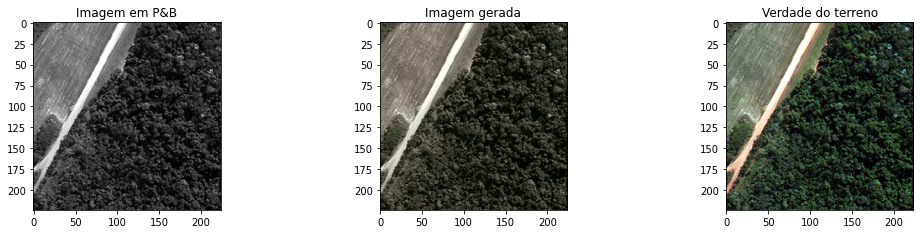

In [103]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img1 = plt.imread('D:/Material de estudo/Engenharia Cartográfica/PFC/Prof/rgb_rend.tif')
img1 = img1[:, :, :3]
img1 = img1[300:524, 300:524, :]
# img1 = plt.imread(os.path.join(ImagePath, imageDir))

img = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Imagem em P&B")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1] = Prediction[:, :, 0]
img_[:,:,2] = Prediction[:, :, 1]


# print(img_[:, :, 0])
# print(img_[:, :, 1])
# print(img_[:, :, 2])
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Imagem gerada")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Verdade do terreno")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [ ]:
# plt.figure(figsize=(30,20))
# plt.subplot(5,5,1)
# img1 = cv2.imread(os.path.join(ImagePath, "10004_9943.jpg"))
# img = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
# img = cv2.resize(img, (224, 224))
# plt.imshow(img)

# plt.subplot(5,5,1+1)
# img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
# img_[:,:,1] = img_ab_reshaped[:, :, 0]
# img_[:,:,2] = img_ab_reshaped[:, :, 1]
# # print(img_[:, :, 0])
# # print(img_[:, :, 1])
# # print(img_[:, :, 2])
# img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
# plt.title("Predicted Image")
# plt.imshow(img_)

# plt.subplot(5,5,1+2)
# plt.title("Ground truth")
# plt.imshow(img1)